4.5

機械学習応用で最重要：
 1. 特徴量選択
 2. 特徴量と機械学習手法との組み合わせ

特徴量の選択戦略 （全て教師あり）（特徴量選択には訓練セットだけ用いる）：
 1. 単変量統計　（モデル不使用）
 2. モデルベース選択　（モデル1つ使用）
 3. 反復選択　（モデル複数使用）


4.5.1

単変量統計:
 - 特徴量とターゲット間の統計的関係を求め、信頼度が最も高い特徴量を採用。
 - クラス分類でいう分散分析（ANOVA:Analysis of Variance)
 - 単変量：　個々の特徴量を個別に考慮　（他の特徴量と組み合わせることで意味を持つものは捨てられる。）
 - テストを選択：
  1. クラス分類： f_classif　（デフォルト値）
  2. 回帰： f_regression
 - テストで求められるp値を元に、特徴量を捨てる方法も指定（p値が過大（yと無関係）な特徴量を捨てる閾値指定）
 - 閾値計算方法： 
  1. SelectKBest　（選択する特徴量数を指定。最も単純。）
  2. SelectPercentile 　(残す特徴量の割合を選択）

 

特徴量抽出（cancer、クラス分類）

In [1]:
# インポート集
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline

In [2]:
# 特徴量抽出（cancer、クラス分類）
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

d = load_breast_cancer()
x,y = d.data, d.target # x：データロードした特徴量
x.shape

(569, 30)

In [3]:
r = np.random.RandomState(42)
n = r.normal(size=(len(x), 50)) # ランダム配列生成（行数：xと同じ行数）（列数：50列）
n.shape

(569, 50)

In [4]:
xn = np.hstack([x,n]) # データロードした特徴量30個　＋　ランダムな50個 = 計80個（水平方向に連結）

ax,ex,ay,ey = train_test_split(xn,y,random_state=0,test_size=.5)

# 訓練セットの形状確認（列の数が特徴量数(80個)を表す）
ax.shape

(284, 80)

In [5]:
#　単変量統計による特徴量選択（50%(半分)選択）
s = SelectPercentile(percentile=50)
s.fit(ax,ay)

axs = s.transform(ax)
axs.shape

C:\Users\toa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(284, 40)

-> 特徴量数が80から40に減少（選別）

In [6]:
# 選択した特徴量（真偽値）
b = s.get_support()
b

C:\Users\toa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False,  True, False, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False, False, False,
        True,  True, False,  True, False, False, False, False])

In [7]:
b.shape

(80,)

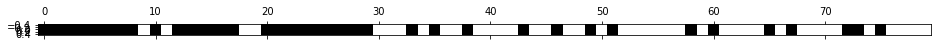

In [8]:
# 選択是非をプロット
plt.matshow(b.reshape(1,-1), cmap='gray_r'); # cmap='gray_r'

-> 前半の特徴量（30/80)のほとんどが選択されている

In [9]:
# ロジスティック回帰で性能比較　（全特徴量の場合と選択された特徴量の場合）
# 全特徴量のスコア(80個)
from sklearn.linear_model import LogisticRegression
exs  = s.transform(ex)
m = LogisticRegression()
m.fit(ax,ay)
m.score(ex,ey) 

C:\Users\toa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.9298245614035088

In [10]:
# 単変量特徴量選択によるスコア(40個)
m.fit(axs, ay)
m.score(exs,ey)

0.9403508771929825

-> 特徴量を選別した方が性能良くなった（92% -> 94%）

4.5.2
モデルベース特徴量選択：
 - 教師あり学習モデルで個々の特徴量の重要性を判断し、重要なものだけ残す手法
 - そのモデルは最終的に使うモデルと異なっても良い
 - モデルは特徴量の重要性の指標を出力するものを用いる（決定系など）
 - 重要性を表す指標（例）：
  - 線形モデルの係数の絶対値
  - 決定木系のfeature_importances_
 - L1ペナルティの線形モデル： 疎な係数を学習 （=特徴量の一部だけ使用） -> これを特徴量選択に使用可能
 - 全ての特徴量を同時に考慮　＝　変数間の交互作用がわかる
 - SelectFromModel変換器を使用
 - 特徴量の重要度が、指定した閾値より大きい特徴量だけ選択


モデルベース特徴量選択：

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
s = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median") # 内部の決定木数：100
s.fit(ax,ay)
ax1 = s.transform(ax)
print(ax.shape)
print(ax1.shape)

C:\Users\toa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


(284, 80)
(284, 40)


-> 特徴量数が半分に減少（80->40)

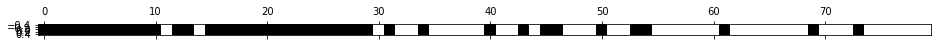

In [12]:
# 採用された特徴量をプロット
b = s.get_support()
plt.matshow(b.reshape(1,-1), cmap='gray_r');

-> 黒が採用された特徴量。約半分が採用されていることがわかる。

In [13]:
# モデルベース特徴量選択によるスコア(40個選択)
ex1 = s.transform(ex)
LogisticRegression().fit(ax1,ay).score(ex1,ey)

0.9508771929824561

-> 性能向上している（重要度の高い特徴量の選択による）

4.5.3 反復特徴量選択
 - 異なる特徴量を用いた一連のモデルを作成　（→計算コスト大（遅い））
 - 特徴量の重要度を表示できるモデルを使用すること
 - 手法：
  1. 特徴量を増やす（ゼロから1つずつ、基準満たすまで増やす）
  2. 特徴量を減らす（全て使用している状態から）
    - 再帰的特徴量削減 　(RFE: Recursive Feature Elimination)
       1. 全ての特徴量からモデルを作り、そのモデルから最も重要度の低い特徴量を削除
       2. 残りの特徴量からモデルを作り、そのモデルから最も重要度の低い特徴量を削除
       3. 最初に指定した特徴量の数になるまで上記を繰り返し

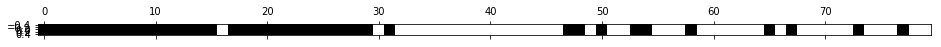

In [14]:
# RFEによる特徴量選択
from sklearn.feature_selection import RFE
s = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
       n_features_to_select=40)
s.fit(ax,ay)
b = s.get_support()
plt.matshow(b.reshape(1,-1), cmap='gray_r');

-> 
 - 3手法の内、最も特徴量選択が良い（最初の30の内29を採用）<br>
 - 遅い（40回ランダムフォレストを実行）



In [15]:
# RFEで選択した特徴量によるロジスティック回帰
axr = s.transform(ax)
exr = s.transform(ex)
LogisticRegression().fit(axr,ay).score(exr,ey)

0.9508771929824561

In [16]:
# RFEで選択した特徴量によるランダムフォレスト（RFE内部のモデル）
s.score(ex,ey)

0.9508771929824561

-> RFEによる特徴量選択で、線形モデルとランダムフォレストの性能が等しくなった


4.6 専門家知識の利用
- 専門家知識＝ドメイン知識、業界の常識（航空券運賃は休前日に高くなる等）
---
- 時系列データの予測：
 - 過去を学習し、未来を予測→　例：前半20日分を訓練データとし、後半10日分をテストデータとする。
 - POSIX時刻：　1970年の1月1日0時からの秒数。（= Unix時刻)

- タスク： レンタル自転車の件数予測
 - ある日時に、家の前のレンタル自転車ステーションで自転車がレンタルされる件数を予測
 - （これがわかれば自分がいつ借りられるかわかる）
 - データ：　2015年8月の1か月間。ある時刻から3時間経過後までにレンタル自転車が借りられた台数。
 - 入力（特徴量）：　日時
 - 出力：　その後3時間のレンタル台数

In [17]:
# データロード
d = mglearn.datasets.load_citibike()
d.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

In [18]:
type(d)

pandas.core.series.Series

In [19]:
d.shape

(248,)

-> 1日8回 * 31日 = 248回 / 1カ月

In [20]:
248 / 30 

8.266666666666667

In [21]:
d[0]

3

In [22]:
d.index

DatetimeIndex(['2015-08-01 00:00:00', '2015-08-01 03:00:00',
               '2015-08-01 06:00:00', '2015-08-01 09:00:00',
               '2015-08-01 12:00:00', '2015-08-01 15:00:00',
               '2015-08-01 18:00:00', '2015-08-01 21:00:00',
               '2015-08-02 00:00:00', '2015-08-02 03:00:00',
               ...
               '2015-08-30 18:00:00', '2015-08-30 21:00:00',
               '2015-08-31 00:00:00', '2015-08-31 03:00:00',
               '2015-08-31 06:00:00', '2015-08-31 09:00:00',
               '2015-08-31 12:00:00', '2015-08-31 15:00:00',
               '2015-08-31 18:00:00', '2015-08-31 21:00:00'],
              dtype='datetime64[ns]', name='starttime', length=248, freq='3H')

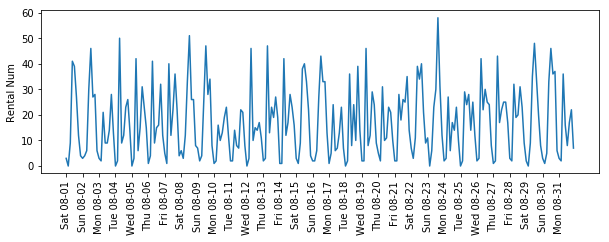

In [23]:
plt.figure(figsize=(10,3))
plt.ylabel('Rental Num')
xticks = pd.date_range(start=d.index.min(), end=d.index.max(), freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90) # ha='left'
plt.plot(d);

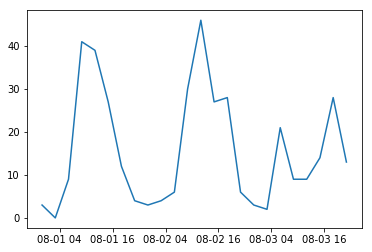

In [24]:
plt.plot(d[:24]);

-> 昼は多く、夜少ない

In [25]:
# 確認
100 // 3**2 # 100 / 9 の割り算の整数部分のみ

11

In [26]:
# 確認。データの行名(日付)を整数化(POSIX時間化)、その値を取り出し１列化（最初の３つ)
d.index.astype("int64").values.reshape(-1,1)[:3]

array([[1438387200000000000],
       [1438398000000000000],
       [1438408800000000000]], dtype=int64)

In [27]:
y = d.values # レンタル自転車が対象の3時間で借りられた台数
x = d.index.astype("int64").values.reshape(-1, 1) // 10**9 
 # データの行名(日付)を整数化、その値を取り出し１列化し、10の9乗で割った整数部分
x[:3]

array([[1438387200],
       [1438398000],
       [1438408800]], dtype=int64)

In [28]:
# 訓練データ数を設定　（1日8回 * 23日 = 184）
n = 184

In [29]:
# 与えられた特徴量セットで回帰モデルを評価しプロットする関数
def def1(f, y, m):
    # 与えられた特徴量を訓練セットとテストセットに分割
    ax, ex = f[:n], f[n:]
    # yも分割
    ay, ey = y[:n], y[n:]
    m.fit(ax, ay)
    
    # R^2スコア算出
    print("test R^2 score: ", m.score(ex,ey))
    
    # 予測
    py = m.predict(ex)
    pya = m.predict(ax)
    
    # プロット(4種類)
    plt.figure(figsize=(8,3))
    plt.xticks(range(0, len(x), 8), xticks.strftime("%a %m-%d"), rotation=90)
    plt.plot(range(n), ay, label="a")
    plt.plot(range(n, len(ey) + n), ey, '-', label="e")
    plt.plot(range(n), pya, '--', label="pa")
    plt.plot(range(n, len(ey) + n), py, '--', label='py')
    plt.legend(loc=(1.01,0))

test R^2 score:  -0.035486463625959086


<Figure size 432x288 with 0 Axes>

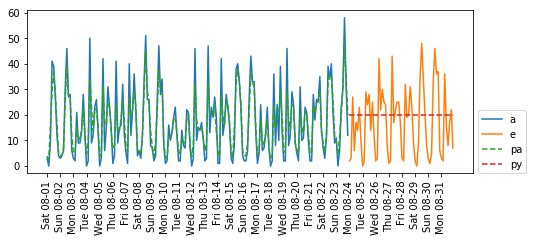

In [30]:
# ランダムフォレスト回帰
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(n_estimators=100, random_state=0)
plt.figure()
def1(x,y,m)

-> 
- テストスコア -0.03　：　全然ダメ
- 予測結果 py は一本の直線：　全然ダメ（全然予測できてない）
- 原因：　特徴量xとランダムフォレストの組み合わせ
 - 決定木は訓練セットの範囲外に外挿不可
   - （訓練セットの特徴量の範囲（1~23日）の外に、テストセットの特徴量の範囲（24~31日）があるということ）
   - （そのため、上限である23日の値を表示するだけになってしまった）
- 改善：　専門家の知識（常識）を使用 -> グラフを眺めると、レンタル台数に関係しているのは時間帯(hour)と曜日ではないか？

-> 
 - まず時間帯を特徴量に使用してみる

In [31]:
# 時間帯を特徴量として作成（hour）（1列）
xh = d.index.hour.values.reshape(-1,1)
xh[:10]

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12],
       [15],
       [18],
       [21],
       [ 0],
       [ 3]], dtype=int64)

test R^2 score:  0.5995775993305429


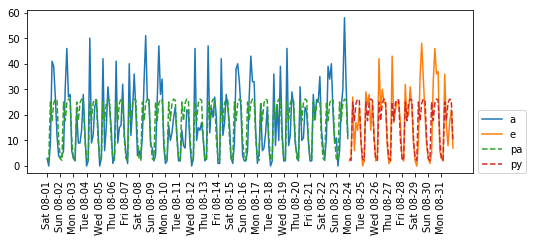

In [32]:
def1(xh, y, m)

-> 予測pyに動きが出たが、毎日同じ波形。R^2スコアははるかに良い。<br>
-> 曜日情報を加えてみる

In [33]:
# 曜日と時間帯の2列を持つ特徴量作成
xhw = np.hstack([d.index.dayofweek.values.reshape(-1,1),
               d.index.hour.values.reshape(-1,1)])
xhw[:10]

array([[ 5,  0],
       [ 5,  3],
       [ 5,  6],
       [ 5,  9],
       [ 5, 12],
       [ 5, 15],
       [ 5, 18],
       [ 5, 21],
       [ 6,  0],
       [ 6,  3]], dtype=int64)

test R^2 score:  0.8419488587966025


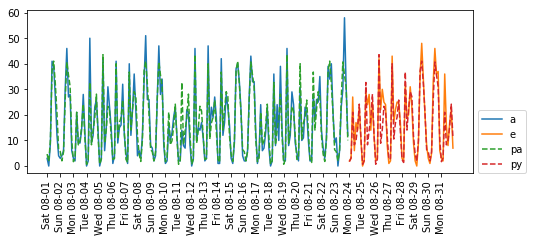

In [34]:
def1(xhw,y,m);

-> ばっちり（予測pyがテストデータにほぼ一致）（R^2スコアも84%）

- LinearRegressionモデルも試す。（ランダムフォレストは複雑なモデルなので、シンプルなモデルとして）

test R^2 score:  0.13204157262163152


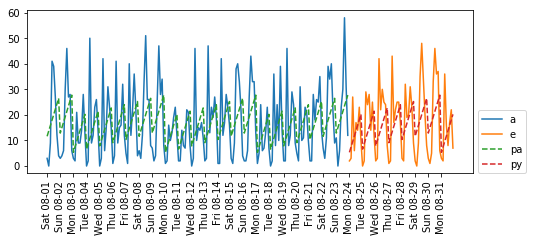

In [35]:
# LinearRegression
from sklearn.linear_model import LinearRegression
def1(xhw,y,LinearRegression());

-> 悪い結果に。(R^2スコア: 13%)
- 原因：　曜日や時間帯の整数が連続値として解釈されているため。
 - 線形モデルは、時刻に対する線形関数としてしか学習できない。→　時刻大でレンタル台数大と学習するだけ。
 - 対策：　整数をワンホットベクトルに変換。（連続値でなく、離散値（カテゴリ変数）として扱える）

In [36]:
# ワンホットベクトル化
from sklearn.preprocessing import OneHotEncoder
e = OneHotEncoder()
xhwo = e.fit_transform(xhw).toarray()
xhwo[:2]

array([[0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

test R^2 score:  0.6191139168658686


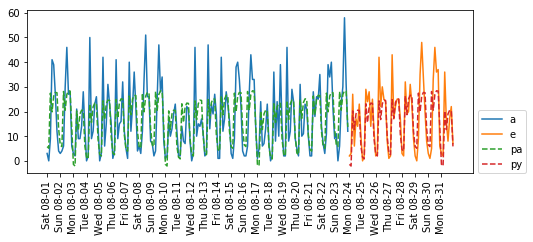

In [37]:
# Ridgeモデル
from sklearn.linear_model import Ridge
m = Ridge()
def1(xhwo, y, m)

-> そこそこに改善した（R^2スコア：62%)
- 線形モデルは曜日と時刻に対してそれぞれ係数を学習している。

  - (曜日と時刻の相互作用について考慮されていない。時刻に対するパターンはすべての曜日で同じ。）

-> 曜日と時刻の組み合わせに対して係数を学習させるには、**交互作用特徴量**を使用。


test R^2 score:  0.8451706357968557


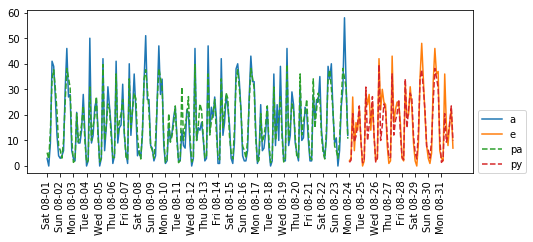

In [38]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
xhwop = p.fit_transform(xhwo)
m = Ridge()
def1(xhwop, y, m)

-> ランダムフォレストと同等の性能に改善（R^2 : 84%)
- このモデルの長所：　何を学習したかが明確。
 - 曜日と時刻の組み合わせに対して係数が1つ。
 - 係数をプロット可能。（ランダムフォレストでは不可能）
    

In [39]:
# 確認（文字列置換の基本形）（%dの部分に%で指定した数字が入る）
"%d" % 1

'1'

In [40]:
# 確認（ゼロ埋め、２桁の場合）
"%02d" % 1

'01'

In [41]:
# 時刻と曜日の特徴量に名前を付ける
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
hour = ["%02d:00" % i for i in range(0,24,3)] # 0~24まで3間隔で取得し、%02dの部分に入れて「03:00」の形にする
hour

['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00']

In [42]:
fs = day + hour # リストの足し算は前のリストの後に後のリストをつなげる形。
fs

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00']

In [43]:
# 交互作用特徴量を名付ける（get_feature_namesメソッド）（組み合わせの総当たり）
fp = p.get_feature_names(fs)
fp

['Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 '00:00',
 '03:00',
 '06:00',
 '09:00',
 '12:00',
 '15:00',
 '18:00',
 '21:00',
 'Mon Tue',
 'Mon Wed',
 'Mon Thu',
 'Mon Fri',
 'Mon Sat',
 'Mon Sun',
 'Mon 00:00',
 'Mon 03:00',
 'Mon 06:00',
 'Mon 09:00',
 'Mon 12:00',
 'Mon 15:00',
 'Mon 18:00',
 'Mon 21:00',
 'Tue Wed',
 'Tue Thu',
 'Tue Fri',
 'Tue Sat',
 'Tue Sun',
 'Tue 00:00',
 'Tue 03:00',
 'Tue 06:00',
 'Tue 09:00',
 'Tue 12:00',
 'Tue 15:00',
 'Tue 18:00',
 'Tue 21:00',
 'Wed Thu',
 'Wed Fri',
 'Wed Sat',
 'Wed Sun',
 'Wed 00:00',
 'Wed 03:00',
 'Wed 06:00',
 'Wed 09:00',
 'Wed 12:00',
 'Wed 15:00',
 'Wed 18:00',
 'Wed 21:00',
 'Thu Fri',
 'Thu Sat',
 'Thu Sun',
 'Thu 00:00',
 'Thu 03:00',
 'Thu 06:00',
 'Thu 09:00',
 'Thu 12:00',
 'Thu 15:00',
 'Thu 18:00',
 'Thu 21:00',
 'Fri Sat',
 'Fri Sun',
 'Fri 00:00',
 'Fri 03:00',
 'Fri 06:00',
 'Fri 09:00',
 'Fri 12:00',
 'Fri 15:00',
 'Fri 18:00',
 'Fri 21:00',
 'Sat Sun',
 'Sat 00:00',
 'Sat 03:00',
 'Sat 06:00',
 'Sat 09:0

In [44]:
# 係数が非ゼロ（存在する）の特徴量だけ残す＋配列化
fn = np.array(fp)[m.coef_ != 0]
fn

array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', '00:00', '03:00',
       '06:00', '09:00', '12:00', '15:00', '18:00', '21:00', 'Mon 00:00',
       'Mon 03:00', 'Mon 06:00', 'Mon 09:00', 'Mon 12:00', 'Mon 15:00',
       'Mon 18:00', 'Mon 21:00', 'Tue 00:00', 'Tue 03:00', 'Tue 06:00',
       'Tue 09:00', 'Tue 12:00', 'Tue 15:00', 'Tue 18:00', 'Tue 21:00',
       'Wed 00:00', 'Wed 03:00', 'Wed 06:00', 'Wed 09:00', 'Wed 12:00',
       'Wed 15:00', 'Wed 18:00', 'Wed 21:00', 'Thu 00:00', 'Thu 03:00',
       'Thu 06:00', 'Thu 09:00', 'Thu 12:00', 'Thu 15:00', 'Thu 18:00',
       'Thu 21:00', 'Fri 00:00', 'Fri 03:00', 'Fri 06:00', 'Fri 09:00',
       'Fri 12:00', 'Fri 15:00', 'Fri 18:00', 'Fri 21:00', 'Sat 00:00',
       'Sat 03:00', 'Sat 06:00', 'Sat 09:00', 'Sat 12:00', 'Sat 15:00',
       'Sat 18:00', 'Sat 21:00', 'Sun 00:00', 'Sun 03:00', 'Sun 06:00',
       'Sun 09:00', 'Sun 12:00', 'Sun 15:00', 'Sun 18:00', 'Sun 21:00'],
      dtype='<U11')

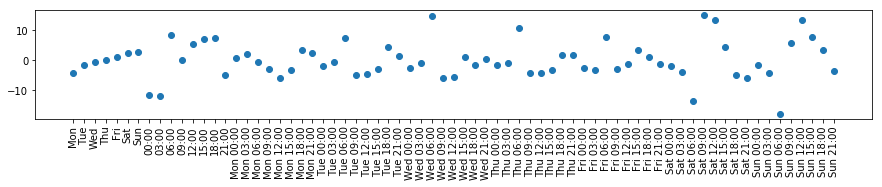

In [45]:
# 係数の内、非ゼロのものだけ取得
cn = m.coef_[m.coef_ != 0]
# 係数(cn)のプロット
plt.figure(figsize=(15,2))
plt.xticks(np.arange(len(cn)), fn, rotation=90)
plt.plot(cn,'o');